In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
class DigitImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Label is the digit before underscore in filename (e.g., 3_00023.png → label 3)
        label = int(os.path.basename(image_path).split('_')[0])
        image = Image.open(image_path).convert('L')  # Grayscale

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Folder where your images are saved
image_folder = "../data_images"
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]

# Split into train and validation (80-20)
train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Transform: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),               # [0,255] -> [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,)) # mean and std for grayscale
])

# Datasets
train_dataset = DigitImageDataset(train_paths, transform=transform)
val_dataset = DigitImageDataset(val_paths, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # (1,28,28) -> (16,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # -> (16,14,14)
            nn.Conv2d(16, 32, 3, padding=1), # -> (32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # -> (32,7,7)
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.network(x)


In [7]:
from tqdm import tqdm  # make sure tqdm is installed

device = torch.device("cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f"✅ Epoch [{epoch+1}/{num_epochs}] finished. Total Loss: {total_loss:.4f}")


✅ Epoch [1/5] finished. Total Loss: 153.8106


✅ Epoch [2/5] finished. Total Loss: 36.9754


✅ Epoch [3/5] finished. Total Loss: 25.4264


✅ Epoch [4/5] finished. Total Loss: 18.0737


✅ Epoch [5/5] finished. Total Loss: 14.7088


In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"✅ Validation Accuracy: {100 * correct / total:.2f}%")

✅ Validation Accuracy: 98.85%


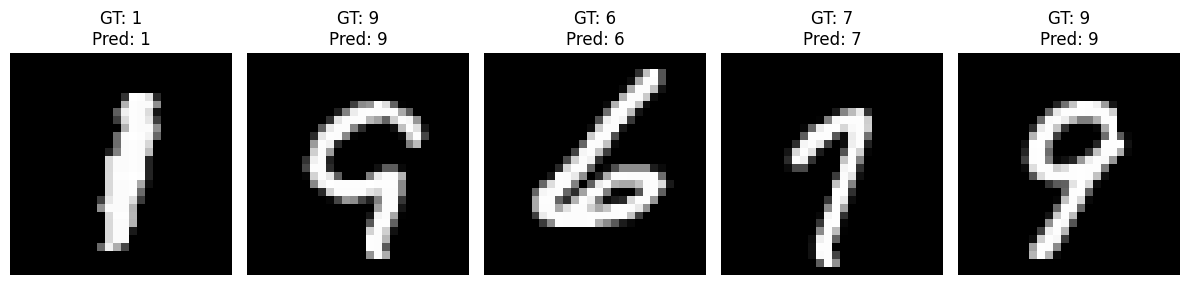

In [10]:
import matplotlib.pyplot as plt
import torch

# Set model to eval mode
model.eval()

# Get one batch from the test loader
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Predict
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Plot 5 images with true and predicted labels
plt.figure(figsize=(12, 4))
for i in range(5):
    image = images[i].cpu().squeeze(0)  # remove channel dimension if grayscale
    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
# Save the model's full object
torch.save(model, "../models/simple_cnn_full.pth")

# Save only the model's state dict (recommended for deployment/reloading)
torch.save(model.state_dict(), "../models/simple_cnn_state_dict.pth")

# Optionally, export to TorchScript for optimized deployment (e.g., on mobile or C++)
example_input = torch.randn(1, 1, 28, 28).to(device)
traced_script_module = torch.jit.trace(model, example_input)
traced_script_module.save("../models/simple_cnn_script.pt")

print("✅ Model saved in multiple formats in 'models/' directory.")

✅ Model saved in multiple formats in 'models/' directory.
